In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error
import math
import seaborn as sb
%matplotlib inline

In [2]:
bloom_dates_training = pd.read_csv('bd_train.xlsx')
bloom_dates_test = pd.read_csv('bd_test.xlsx')
bloom_dates_training.drop(['Unnamed: 0'],axis=1,inplace=True)
bloom_dates_test.drop(['Unnamed: 0'],axis=1,inplace=True)
    
pd.options.display.max_rows=500
pd.options.mode.chained_assignment = None

tokyo_data = pd.read_csv('tokyo.csv')
    
tokyo_data = tokyo_data.drop(['Unnamed: 0'],axis=1).rename(index=str, columns={"現地平均気圧": "average pressure", "海面平均気圧": "sea surface pressure", "合計降水量": 'total precipitation', "1時間最大降水量":"1 hour precipitation",
                                             "10分間最大降水量" : "10 min precipitation", "平均気温": "average temp", 
                                             "最高気温" :  "maximum temperature", "最低気温": 'lowest temperature',
                                             "平均湿度": "average humidity", "最低湿度" : "lowest humidity", "日照時間" : "sunshine"})

test_years = [1966,1971,1985,1994,2008]
training_years = tokyo_data[~tokyo_data['year'].isin(test_years)].year.unique()

In [3]:
tokyo_data.describe()

,year,month,day,average pressure,sea surface pressure,total precipitation,1 hour precipitation,10 min precipitation,average temp,maximum temperature,lowest temperature,average humidity,lowest humidity,sunshine
count,20544.000000,20544.000000,20544.000000,20544.000000,20544.000000,20544.000000,20544.000000,20544.00000,20544.000000,20544.000000,20544.000000,20544.000000,20544.000000,20544.000000
mean,1988.625876,6.503115,15.728777,1009.858304,1013.814413,4.082978,1.504196,0.57298,16.033022,19.914871,12.574815,62.706873,45.173871,5.338016
std,16.237657,3.454602,8.799930,6.811289,6.810376,12.445912,4.309710,1.64613,7.893209,7.972881,8.205670,15.571041,16.925758,3.990114
min,1961.000000,1.000000,1.000000,975.900000,980.100000,0.000000,0.000000,0.00000,-1.200000,-0.200000,-5.500000,19.000000,6.000000,0.000000
25%,1975.000000,3.000000,8.000000,1005.200000,1009.100000,0.000000,0.000000,0.00000,8.700000,12.900000,5.000000,51.000000,31.000000,1.000000
50%,1989.000000,7.000000,16.000000,1009.800000,1013.700000,0.000000,0.000000,0.00000,16.400000,20.200000,12.800000,64.000000,45.000000,5.900000
75%,2003.000000,10.000000,23.000000,1014.600000,1018.600000,1.500000,1.000000,0.50000,22.500000,26.300000,19.600000,74.000000,57.000000,8.800000
max,2017.000000,12.000000,31.000000,1033.100000,1037.000000,259.500000,82.500000,35.00000,33.200000,39.500000,30.400000,100.000000,100.000000,13.800000


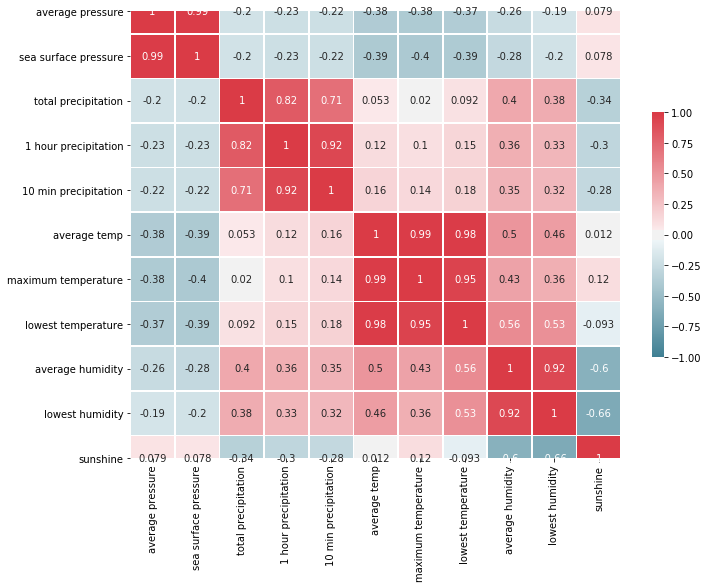

In [4]:
corr = tokyo_data.drop(labels=['year','month','day'],axis=1).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sb.diverging_palette(220, 10, as_cmap=True)

sb.heatmap(corr, cmap=cmap, vmax=1,vmin=-1, center=0,
            square=True, linewidths=.7, cbar_kws={"shrink": .5},annot=True)

In [5]:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
tokyo_data.drop(labels=to_drop,axis=1,inplace=True)

In [6]:
import datetime
def return_date(y,m,d):
    return datetime.datetime(y,m,d)

def week_of_year(date):
    return date.isocalendar()[1]

bloom_dates_training["date"] = bloom_dates_training.apply(lambda row: return_date(row['year'],
                                                                                 row['month'],
                                                                                 row['day']),
                                                                                 axis=1)

bloom_dates_test["date"] = bloom_dates_test.apply(lambda row: return_date(row['year'],
                                                                                 row['month'],
                                                                                 row['day']),
                                                                                 axis=1)

bloom_dates_training["week of year"] = bloom_dates_training.apply(lambda row: week_of_year(row['date']) ,axis=1)

bloom_dates_test["week of year"] = bloom_dates_test.apply(lambda row: week_of_year(row['date']), axis=1)

In [7]:
bloom_dates_training[['year','month','day']].to_csv('bd_train.xlsx')

In [8]:
bloom_dates_test[['year','month','day']].to_csv('bd_test.xlsx')

In [9]:
monthly_averages_by_year_train = []
for year in training_years:
    months = tokyo_data[tokyo_data['year']==year].month.unique()
    for m in months:
        ap,tp,at,ah,sun = tokyo_data[tokyo_data['year']==year][tokyo_data['month']==m].mean(axis=0)[3:]
        monthly_averages_by_year_train.append([year,m,ap,tp,at,ah,sun])
        
monthly_averages_by_year_test = []
for year in test_years:
    months = tokyo_data[tokyo_data['year']==year].month.unique()
    for m in months:
        ap,tp,at,ah,sun = tokyo_data[tokyo_data['year']==year][tokyo_data['month']==m].mean(axis=0)[3:]
        monthly_averages_by_year_test.append([year,m,ap,tp,at,ah,sun])

C:\Users\thebe\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\thebe\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


In [10]:
mask = tokyo_data.columns != 'day'
tokyo_data_train = pd.DataFrame(np.array(monthly_averages_by_year_train),columns=tokyo_data.columns[mask])
tokyo_data_test = pd.DataFrame(np.array(monthly_averages_by_year_test),columns=tokyo_data.columns[mask])
tokyo_data_train = tokyo_data_train.astype({'year':int, 'month': int})
tokyo_data_test = tokyo_data_test.astype({'year':int, 'month': int})
tokyo_data = pd.concat([tokyo_data_train,tokyo_data_test],ignore_index=True)
tokyo_data.sort_values(by=['year','month'],inplace=True)

In [11]:
test_years = [1966,1971,1985,1994,2008]
training_years = tokyo_data[~tokyo_data['year'].isin(test_years)].year.unique()

tokyo_training = pd.DataFrame(columns = tokyo_data.columns)
for year in training_years:
    tokyo_training = tokyo_training.append(tokyo_data_train[tokyo_data_train['year']==year],ignore_index=True)
    
tokyo_test = pd.DataFrame(columns=tokyo_data.columns)
for year in test_years:
    tokyo_test = tokyo_test.append(tokyo_data_test[tokyo_data_test['year']==year], ignore_index=True)

In [12]:
tokyo_training.head()

,year,month,average pressure,total precipitation,average temp,average humidity,sunshine
0,1961,1,1015.245161,1.258065,3.570968,54.032258,5.922581
1,1961,2,1011.821429,1.553571,4.528571,48.750000,7.067857
2,1961,3,1016.903226,3.438710,8.222581,60.870968,5.841935
3,1961,4,1013.890000,6.103333,14.920000,62.933333,6.860000
4,1961,5,1011.229032,1.790323,19.780645,69.064516,6.167742


In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaling_columns = tokyo_training.columns[2:]
tokyo_training[scaling_columns] = scaler.fit_transform(tokyo_training[scaling_columns])
tokyo_test[scaling_columns] = scaler.transform(tokyo_test[scaling_columns])
tokyo_training.describe()

,average pressure,total precipitation,average temp,average humidity,sunshine
count,615.000000,615.000000,615.000000,615.000000,615.000000
mean,0.471922,0.161748,0.487047,0.531791,0.543617
std,0.206125,0.116746,0.281321,0.197523,0.169702
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.312057,0.076282,0.215184,0.385154,0.430172
50%,0.478040,0.142949,0.492479,0.543257,0.548581
75%,0.625916,0.214217,0.742189,0.697591,0.656512
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
X_train = []
for year in training_years:    
    X_train.append(np.array(tokyo_training[tokyo_training['year'] == year].head(2).drop(labels=['year','month'],axis=1)))
    
X_test = []
for year in test_years:    
    X_test.append(np.array(tokyo_test[tokyo_test['year'] == year].head(2).drop(labels=['year','month'],axis=1)))
    
X_train = np.array(X_train).reshape(-1,10)
X_test = np.array(X_test).reshape(-1,10)

In [15]:
print(X_train.shape)
print(X_test.shape)

(52, 10)
(5, 10)


In [16]:
y_train = np.array(bloom_dates_training['week of year'])
y_test = np.array(bloom_dates_test['week of year'])

In [17]:
print(y_train.shape)
print(y_test.shape)

(52,)
(5,)


In [18]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train,y_train)
X_test, y_test = shuffle(X_test,y_test) 

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization, Dropout

In [20]:
#training sequence
# model = Sequential()
# model.add(Dense(64, input_shape=(10,), activation='relu'))
# # simple_model.add(Dense(32, activation='relu'))
# model.add(Dense(1))

# loss = 'mean_squared_error'
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.3,decay=1e-6)
# model.compile(optimizer,
#               loss,
#              metrics=['mse'])

# model.fit(x=X_train,y=y_train,
#           batch_size=8,
#           epochs=20,
#           validation_data=(X_test,y_test))

model = tf.keras.models.load_model('nn_model')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [21]:
accuracy = 1 - np.sum(abs(y_test.reshape(-1,1) - np.round(model.predict(X_test),0)))/X_test.shape[0]
print('accuracy: ', accuracy)

accuracy:  0.8


In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
rf = RandomForestClassifier()

In [24]:
rf.fit(X_train,y_train)

C:\Users\thebe\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [25]:
print('accuracy of random forest model', rf.score(X_test,y_test))

accuracy of random forest model 0.6
